In [106]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(font_scale=.75)

from sklearn.datasets import make_moons, make_classification, load_iris
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# Support Vector Machines

In [31]:
def create_meshgrid(X):
    return np.meshgrid(
            np.linspace(X[:, 0].min(), X[:, 0].max(), len(X)), 
            np.linspace(X[:, 1].min(), X[:, 1].max(), len(X))
        )

def predict_and_plot(clf, X, y, *, include_decision=True, ax=None):
    if ax is None:
        ax = plt.gca()

    cmap = plt.get_cmap("RdBu")
    
    mesh_x1, mesh_x2 = create_meshgrid(X)

    X_test = np.c_[mesh_x1.ravel(), mesh_x2.ravel()]

    y_pred = clf.predict(X_test).reshape(mesh_x1.shape)
    
    ax.contourf(mesh_x1, mesh_x2, y_pred, cmap=cmap, alpha=.5)

    if include_decision:
        y_desision = clf.decision_function(X_test).reshape(mesh_x1.shape)
        ax.contourf(mesh_x1, mesh_x2, y_desision, cmap=cmap, alpha=.25)

    sns.scatterplot(x=X[:, 0], y=X[:, 1], c=y, cmap=cmap, alpha=.8, ax=ax)
    score = cross_val_score(clf, X, y).mean()
    ax.text(1.5, .85, f"Score: {score:.2f}")
    ax.set(xlim=(mesh_x1.min()-.1, mesh_x1.max()+.1), ylim=(mesh_x2.min()-.1, mesh_x2.max()+.1))

In [46]:
X = np.array([
    [1, 5], 
    [2, 6], 
    [3, 7], 
    [4, 8],
    [5, 9]
    ])

meshgrid_x, meshgrid_y = create_meshgrid(X)

In [ ]:
X[:, 0]

In [ ]:
meshgrid_x, meshgrid_y

In [ ]:
sns.scatterplot(x=meshgrid_x.ravel(), y=meshgrid_y.ravel())

In [ ]:
classes = [0, 0, 1, 1, 1, 1, 1, 0, 0]
sns.scatterplot(x=np.arange(-4, 5), y=0, hue=classes, style=classes)

In [ ]:
classes = [0, 0, 1, 1, 1, 1, 1, 0, 0]
sns.scatterplot(x=np.arange(-4, 5), y=np.arange(-4, 5)**2, hue=classes, style=classes)
sns.lineplot(x=np.arange(-4, 5), y=6)

In [110]:
X, y = make_moons(noise=.15, random_state=23)

In [ ]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.get_cmap("RdBu"), alpha=.8)

### LinearSVC

En linjär SVC får problem att hitta en passande linje eftersom klasserna inte är ickelinjärt uppdelade.

In [ ]:
clf = make_pipeline(
    StandardScaler(), 
    LinearSVC(C=10, max_iter=10000, dual=True, loss="hinge")
    )
clf.fit(X, y)

In [ ]:
predict_and_plot(clf, X, y, include_decision=True)

Som vi såg förra veckan kan vi använda `PolynomialFeatures` för att skapa nya kolumner med ickelinjära *features*. Det hjälper vår `LinearSVC` ganska mycket.

In [ ]:
poly_feat_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10000, dual=True, loss="hinge")
    )

poly_feat_clf.fit(X, y)

In [ ]:
predict_and_plot(poly_feat_clf, X, y)

In [ ]:
poly_feat_clf.named_steps["linearsvc"].coef_

När vi använder *Support Vector Machines* finns det dock ett annat trick vi kan använda för att får fram ickelinjära relationer.

Istället för en `LinearSVC` kan vi använda en `SVC` och sätta `kernel`-parametern till `"poly"`.

Skillnaden är att en `SVC` med en *polynomial kernel* använder sig av ett matematiskt trick som ger samma resultat som om vi lade till *polynomial features*, utan att faktiskt behöva göra det, vilket sparar lagringsutrymme och beräkningskraft.

In [ ]:
poly_kernel_clf = make_pipeline(
    StandardScaler(), 
    SVC(kernel="poly", degree=3, coef0=1, C=10))
poly_kernel_clf.fit(X, y)

In [ ]:
predict_and_plot(poly_kernel_clf, X, y)

In [ ]:
poly_kernel_clf_3 = make_pipeline(
    StandardScaler(), 
    SVC(kernel="poly", degree=3, coef0=1, C=10))

poly_kernel_clf_3.fit(X, y)

In [ ]:
poly_kernel_clf_10 = make_pipeline(
    StandardScaler(), 
    SVC(kernel="poly", degree=10, coef0=1, C=10))
poly_kernel_clf_10.fit(X, y)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

predict_and_plot(poly_kernel_clf_3, X, y, ax=axs[0])
predict_and_plot(poly_kernel_clf_10, X, y, ax=axs[1])

Vi kan använda `GridSearchCV` för att testa oss fram till de bästa värdena på hyperparametrarna. 

In [ ]:
gsv_pipeline = make_pipeline(StandardScaler(), SVC(kernel="poly"))

param_grid = {
    "svc__degree": [2, 3, 5, 10],
    "svc__coef0": [0, 0.5, 1],
    "svc__C": [1, 10, 100]
}

gs_clf = GridSearchCV(gsv_pipeline, param_grid=param_grid)
gs_clf.fit(X, y)

In [ ]:
predict_and_plot(gs_clf, X, y)

In [ ]:
rbf1 = SVC(kernel="rbf", gamma=.1, C=.001)
rbf1.fit(X, y)

rbf2 = SVC(kernel="rbf", gamma=.1, C=1000)
rbf2.fit(X, y)

rbf3 = SVC(kernel="rbf", gamma=5, C=.001)
rbf3.fit(X, y)

rbf4 = SVC(kernel="rbf", gamma=5, C=1000)
rbf4.fit(X, y)

fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True, layout="constrained")

for ax, model in zip(axs.flatten(), [rbf1, rbf2, rbf3, rbf4]):
    predict_and_plot(model, X, y, ax=ax)
    ax.set(title=f"C: {model.get_params()["C"]}, $\\gamma$={model.get_params()["gamma"]}")
    # print(ax)


In [ ]:
gsv_pipeline = make_pipeline(StandardScaler(), SVC(kernel="rbf"))
param_grid = {
    "svc__gamma": [.1, 1, 5, 50, 100],
    "svc__C": [1, 10, 100]
}
gs_clf = GridSearchCV(gsv_pipeline, param_grid=param_grid)
gs_clf.fit(X, y)

In [ ]:
predict_and_plot(gs_clf, X, y)

In [72]:
X, y = make_moons(n_samples=200, noise=.15, random_state=16)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
gs_clf.fit(X_train, y_train)

In [ ]:
predict_and_plot(gs_clf, X_train, y_train)

In [ ]:
predict_and_plot(gs_clf, X_test, y_test)

---
## Feature engineering med Iris

In [138]:
iris = load_iris(as_frame=True)

In [139]:
iris.data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


<Axes: xlabel='petal length (cm)', ylabel='petal width (cm)'>

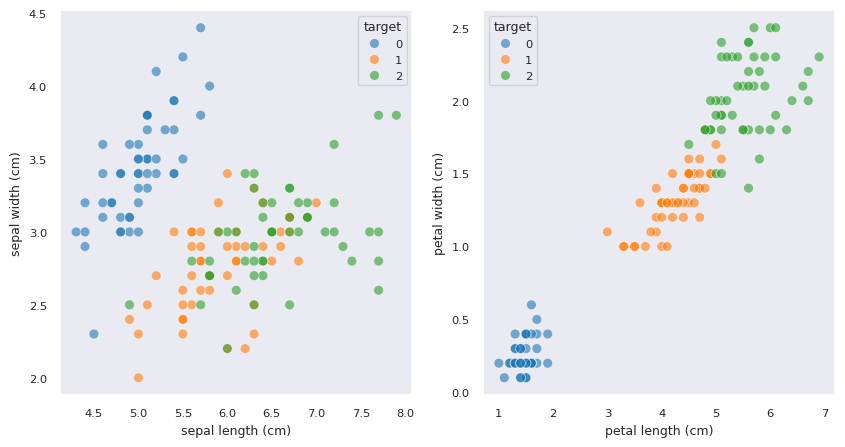

In [131]:
sns.set_theme(style="dark", font_scale=.75)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(iris.data, x="sepal length (cm)", y="sepal width (cm)", hue=iris.target, palette="tab10", alpha=.6, s=50, ax=axs[0])
sns.scatterplot(iris.data, x="petal length (cm)", y="petal width (cm)", hue=iris.target, palette="tab10", alpha=.6, s=50, ax=axs[1])

In [140]:
iris.data["sepal_area"] = iris.data["sepal length (cm)"] * iris.data["sepal width (cm)"]
iris.data["petal_area"] = iris.data["petal length (cm)"] * iris.data["petal width (cm)"]

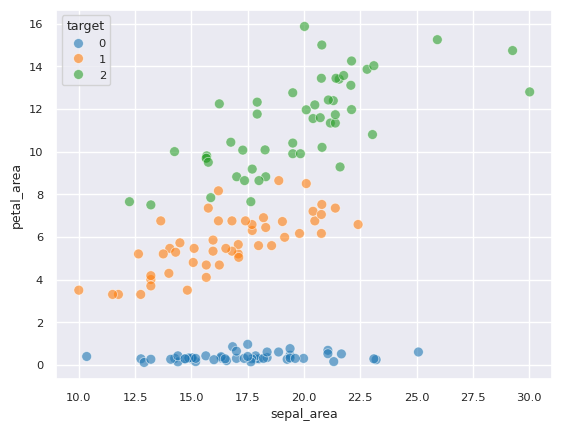

In [133]:
sns.scatterplot(iris.data, x="sepal_area", y="petal_area", hue=iris.target, palette="tab10", alpha=.6, s=50)
plt.grid()

In [141]:
iris.data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),sepal_area,petal_area
0,5.1,3.5,1.4,0.2,17.85,0.28
1,4.9,3.0,1.4,0.2,14.70,0.28
2,4.7,3.2,1.3,0.2,15.04,0.26
3,4.6,3.1,1.5,0.2,14.26,0.30
4,5.0,3.6,1.4,0.2,18.00,0.28
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,20.10,11.96
146,6.3,2.5,5.0,1.9,15.75,9.50
147,6.5,3.0,5.2,2.0,19.50,10.40
148,6.2,3.4,5.4,2.3,21.08,12.42


In [148]:

X_train, X_test, y_train, y_test = train_test_split(iris.data.iloc[:, -2:], iris.target, random_state=23)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train, y_train)
# X_test = scaler.transform(X_test, y_test)

<Axes: >

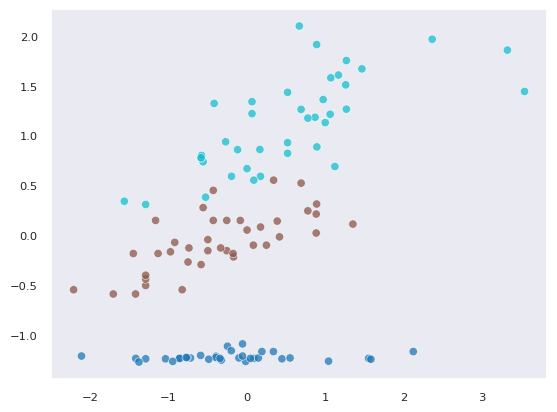

In [149]:
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], c=y_train, cmap=plt.get_cmap("tab10"), alpha=.75)

In [150]:
poly_kernel_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, coef0=1, kernel='poly'))])

ValueError: cannot reshape array of size 37632 into shape (112,112)

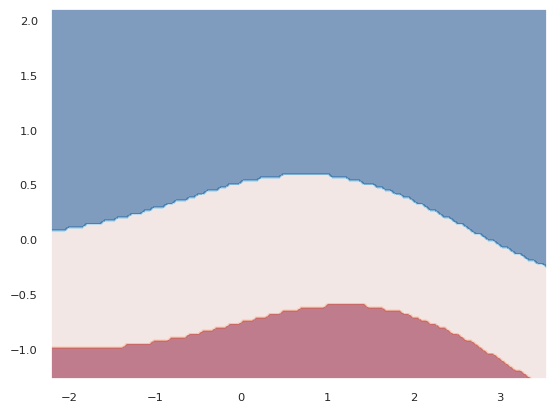

In [151]:
predict_and_plot(poly_kernel_clf, X_train[:, -2:], y_train)

In [28]:
y_pred = cross_val_predict(poly_kernel_clf, X_train, y_train)
cm = confusion_matrix(y_train, y_pred)

In [ ]:
ConfusionMatrixDisplay(cm).plot(cmap=plt.get_cmap("RdBu"), text_kw={"c": "white"})
plt.grid(False)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [ ]:
predict_and_plot(logreg, X_train, y_train)